<a href="https://colab.research.google.com/github/p33ves/CMPT726-ML-Project/blob/main/K_means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

K-Means Clustering Model

In [618]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

Loading dataset from Github repo

In [619]:
#Get preprocessed final table
cust_data = pd.read_csv('https://raw.githubusercontent.com/p33ves/CMPT726-ML-Project/main/processed_datasets/profile_features.csv')
cust_data.head()

,Unnamed: 0,gender,age,cust_id,became_member_on,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,Total transaction,offer completed_via_email,offer completed_via_social,offer completed_via_mobile,offer completed_via_web,offer completed bogo count,offer completed discount count,offer received_via_email,offer received_via_social,offer received_via_mobile,offer received_via_web,offer received bogo count,offer received discount count,offer received informational count,offer viewed_via_email,offer viewed_via_social,offer viewed_via_mobile,offer viewed_via_web,offer viewed bogo count,offer viewed discount count,offer viewed informational count,Total transaction amount,avg_difficulty,avg_duration,total_reward_received,total_reward_defined,total_view_ratio,total_completion_ratio,avg_transaction_amt,transactions_per_membership_days,customer_type
0,0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1230,1.0,2.0,0.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.01,3.333333,144.000000,5.0,5.0,0.00,0.500,25.67,0.002439,passive
1,1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1297,3.0,4.0,4.0,7.0,3.0,2.0,3.0,2.0,3.0,0.0,4.0,3.0,4.0,2.0,3.0,0.0,1.0,4.0,3.0,4.0,2.0,3.0,0.0,1.0,159.27,5.454545,137.454545,20.0,20.0,1.00,0.750,22.75,0.005397,active
2,2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,945,2.0,4.0,3.0,3.0,2.0,1.0,2.0,2.0,1.0,1.0,4.0,1.0,4.0,4.0,1.0,2.0,1.0,3.0,1.0,3.0,3.0,1.0,2.0,0.0,57.73,7.222222,184.000000,7.0,9.0,0.75,0.500,19.24,0.003175,passive
3,3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1021,5.0,6.0,6.0,3.0,5.0,3.0,5.0,5.0,3.0,2.0,6.0,3.0,6.0,6.0,4.0,2.0,0.0,6.0,3.0,6.0,6.0,4.0,2.0,0.0,36.43,6.764706,163.764706,19.0,24.0,1.00,0.833,12.14,0.002938,active
4,4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1111,1.0,3.0,2.0,4.0,1.0,1.0,1.0,1.0,0.0,1.0,3.0,2.0,3.0,3.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0,15.62,7.333333,192.000000,2.0,5.0,0.67,0.333,3.90,0.003600,passive


In [620]:
cust_data.columns

Index(['Unnamed: 0', 'gender', 'age', 'cust_id', 'became_member_on', 'income',
       'days_as_member', 'Total offer completed', 'Total offer received',
       'Total offer viewed', 'Total transaction', 'offer completed_via_email',
       'offer completed_via_social', 'offer completed_via_mobile',
       'offer completed_via_web', 'offer completed bogo count',
       'offer completed discount count', 'offer received_via_email',
       'offer received_via_social', 'offer received_via_mobile',
       'offer received_via_web', 'offer received bogo count',
       'offer received discount count', 'offer received informational count',
       'offer viewed_via_email', 'offer viewed_via_social',
       'offer viewed_via_mobile', 'offer viewed_via_web',
       'offer viewed bogo count', 'offer viewed discount count',
       'offer viewed informational count', 'Total transaction amount',
       'avg_difficulty', 'avg_duration', 'total_reward_received',
       'total_reward_defined', 'total_view_

Adding label

In [621]:
#dropping columns that are not required for clustering
#select columns that are for clustering
cust_data['bogo_comp_perc'] = cust_data['offer completed bogo count'] / cust_data['Total offer completed']
cust_data['discount_comp_perc'] = cust_data['offer completed discount count'] / cust_data['Total offer completed']

cust_data['bogo_view_perc'] = cust_data['offer viewed bogo count'] / cust_data['Total offer viewed']
cust_data['discount_view_perc'] = cust_data['offer viewed discount count'] / cust_data['Total offer viewed']
cust_data['info_view_perc'] = cust_data['offer viewed informational count'] / cust_data['Total offer viewed']

cust_data['bogo_rec_perc'] = cust_data['offer received bogo count'] / cust_data['Total offer received']
cust_data['discount_rec_perc'] = cust_data['offer received discount count'] / cust_data['Total offer received']
cust_data['info_rec_perc'] = cust_data['offer received informational count'] / cust_data['Total offer received']

cust_data['bogo_comp_ratio'] = cust_data['offer completed bogo count'] / cust_data['offer received bogo count']
cust_data['discount_comp_ratio'] = cust_data['offer completed discount count'] / cust_data['offer received discount count']

cust_data['bogo_view_ratio'] = cust_data['offer viewed bogo count'] / cust_data['offer received bogo count']
cust_data['discount_view_ratio'] = cust_data['offer viewed discount count'] / cust_data['offer received discount count']
cust_data['info_view_ratio'] = cust_data['offer viewed informational count'] / cust_data['offer received informational count']

data = cust_data[['gender','age','income', 'days_as_member', 
'Total offer completed', 'Total offer received','Total offer viewed',
'offer completed bogo count', 'offer completed discount count', 'offer received bogo count', 'offer received discount count', 'offer received informational count', 'offer viewed bogo count', 'offer viewed discount count', 'offer viewed informational count',
'bogo_comp_perc','discount_comp_perc', 'bogo_view_perc','discount_view_perc', 'info_view_perc',
'bogo_rec_perc','discount_rec_perc', 'info_rec_perc',
'bogo_comp_ratio','discount_comp_ratio','bogo_view_ratio','discount_view_ratio', 'info_view_ratio',
'avg_difficulty','avg_duration', 'total_reward_received', 'avg_transaction_amt']]

data.sample(5)
# cust_data.sample(5)

,gender,age,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,offer completed bogo count,offer completed discount count,offer received bogo count,offer received discount count,offer received informational count,offer viewed bogo count,offer viewed discount count,offer viewed informational count,bogo_comp_perc,discount_comp_perc,bogo_view_perc,discount_view_perc,info_view_perc,bogo_rec_perc,discount_rec_perc,info_rec_perc,bogo_comp_ratio,discount_comp_ratio,bogo_view_ratio,discount_view_ratio,info_view_ratio,avg_difficulty,avg_duration,total_reward_received,avg_transaction_amt
12270,F,79,77000.0,1117,3.0,5.0,4.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,0.666667,0.333333,0.50,0.25,0.25,0.400000,0.200000,0.4,1.0,1.0,1.000000,1.000000,0.5,8.750000,144.000000,20.0,17.68
8276,F,76,114000.0,1939,5.0,5.0,4.0,2.0,3.0,2.0,3.0,0.0,2.0,2.0,0.0,0.400000,0.600000,0.50,0.50,0.00,0.400000,0.600000,0.0,1.0,1.0,1.000000,0.666667,NaN,8.285714,173.142857,22.0,28.39
14047,M,58,49000.0,1734,2.0,3.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.500000,0.500000,1.00,0.00,0.00,0.333333,0.666667,0.0,1.0,0.5,1.000000,0.000000,NaN,11.666667,156.000000,12.0,14.55
8996,M,93,48000.0,1628,3.0,5.0,4.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,0.333333,0.666667,0.25,0.50,0.25,0.200000,0.400000,0.4,1.0,1.0,1.000000,1.000000,0.5,8.000000,152.000000,13.0,12.01
10019,F,81,85000.0,1436,5.0,5.0,4.0,3.0,2.0,3.0,2.0,0.0,2.0,2.0,0.0,0.600000,0.400000,0.50,0.50,0.00,0.600000,0.400000,0.0,1.0,1.0,0.666667,1.000000,NaN,8.642857,162.857143,30.0,22.13


In [622]:
data.shape

(14825, 32)

In [623]:
#Conerting genders into numeric data
data['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [624]:
data['gender'].replace({'M':0, 'F':1,'O':2}, inplace=True)
data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,gender,age,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,offer completed bogo count,offer completed discount count,offer received bogo count,offer received discount count,offer received informational count,offer viewed bogo count,offer viewed discount count,offer viewed informational count,bogo_comp_perc,discount_comp_perc,bogo_view_perc,discount_view_perc,info_view_perc,bogo_rec_perc,discount_rec_perc,info_rec_perc,bogo_comp_ratio,discount_comp_ratio,bogo_view_ratio,discount_view_ratio,info_view_ratio,avg_difficulty,avg_duration,total_reward_received,avg_transaction_amt
0,1,55,112000.0,1230,1.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,0.500000,0.000000,0.500000,1.00,NaN,0.0,NaN,0.0,3.333333,144.000000,5.0,25.67
1,1,75,100000.0,1297,3.0,4.0,4.0,3.0,0.0,3.0,0.0,1.0,3.0,0.0,1.0,1.0,0.0,0.750000,0.000000,0.25,0.750000,0.000000,0.250000,1.00,NaN,1.0,NaN,1.0,5.454545,137.454545,20.0,22.75
2,0,68,70000.0,945,2.0,4.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.5,0.5,0.333333,0.666667,0.00,0.250000,0.500000,0.250000,1.00,0.5,1.0,1.0,0.0,7.222222,184.000000,7.0,19.24
3,0,65,53000.0,1021,5.0,6.0,6.0,3.0,2.0,4.0,2.0,0.0,4.0,2.0,0.0,0.6,0.4,0.666667,0.333333,0.00,0.666667,0.333333,0.000000,0.75,1.0,1.0,1.0,NaN,6.764706,163.764706,19.0,12.14
4,0,58,51000.0,1111,1.0,3.0,2.0,0.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,0.000000,1.000000,0.00,0.000000,0.666667,0.333333,NaN,0.5,NaN,1.0,0.0,7.333333,192.000000,2.0,3.90


In [625]:
#Filling in avg_amount null values with Imputer
from sklearn.impute import SimpleImputer 

imputer = SimpleImputer(strategy = 'median')
data_imp = pd.DataFrame(imputer.fit_transform(data))

In [626]:
data.shape

(14825, 32)

In [627]:
#Standardscaler to scale the data
data_scaled = StandardScaler().fit_transform(data_imp)
data_scaled

array([[ 1.06355702,  0.03488876,  2.15741893, ..., -0.53950967,
        -0.62221469,  0.65169175],
       [ 1.06355702,  1.18543027,  1.60180089, ..., -0.79136381,
         1.01514395,  0.47484409],
       [-0.84253979,  0.78274074,  0.2127558 , ...,  0.99959896,
        -0.40390021,  0.2622635 ],
       ...,
       [-0.84253979, -0.31027369,  0.35166031, ..., -1.46297485,
        -1.16800091, -0.60198861],
       [ 1.06355702,  1.64564687, -0.71327427, ..., -0.23168795,
         1.56093017, -0.08234718],
       [ 1.06355702,  0.43757829,  0.76837384, ..., -1.00124226,
        -0.29474296,  0.54085914]])

In [628]:
data_cluster = pd.DataFrame(data_scaled, columns = data.columns).dropna()
data_cluster.head()

,gender,age,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,offer completed bogo count,offer completed discount count,offer received bogo count,offer received discount count,offer received informational count,offer viewed bogo count,offer viewed discount count,offer viewed informational count,bogo_comp_perc,discount_comp_perc,bogo_view_perc,discount_view_perc,info_view_perc,bogo_rec_perc,discount_rec_perc,info_rec_perc,bogo_comp_ratio,discount_comp_ratio,bogo_view_ratio,discount_view_ratio,info_view_ratio,avg_difficulty,avg_duration,total_reward_received,avg_transaction_amt
0,1.063557,0.034889,2.157419,-0.349433,-0.742678,-2.313047,-2.604592,-0.017517,-1.050678,-0.707758,-1.591813,0.117481,-1.414305,-1.220437,-0.827778,1.674916,-1.674916,0.175555,-0.115927,-0.798382,0.417697,-1.663723,1.534467,1.020112,0.768385,-3.037058,0.735129,-2.287517,-1.819481,-0.539510,-0.622215,0.651692
1,1.063557,1.185430,1.601801,-0.189601,0.534237,-0.451989,0.493128,1.871174,-1.050678,1.083996,-1.591813,0.117481,1.439781,-1.220437,0.483312,1.674916,-1.674916,1.021875,-1.284219,0.287776,1.458629,-1.663723,0.257448,1.020112,0.768385,0.521835,0.735129,0.514554,-0.958991,-0.791364,1.015144,0.474844
2,-0.842540,0.782741,0.212756,-1.029314,-0.104220,-0.451989,-0.281302,-0.017517,-0.132805,-0.707758,0.178261,0.117481,-0.462943,0.739693,-0.827778,0.096256,-0.096256,-0.388658,1.052365,-0.798382,-0.623234,0.412203,0.257448,1.020112,-0.438504,0.521835,0.735129,-2.287517,-0.241916,0.999599,-0.403900,0.262264
3,-0.842540,0.610160,-0.574370,-0.848012,1.811152,1.409069,2.041988,1.871174,0.785067,1.979873,0.178261,-1.024585,2.391143,0.739693,-0.827778,0.411988,-0.411988,0.739768,-0.115927,-0.798382,1.111652,-0.279773,-1.019571,0.413895,0.768385,0.521835,0.735129,0.514554,-0.427512,0.220991,0.905987,-0.167743
4,-0.842540,0.207470,-0.666973,-0.633313,-0.742678,-1.382518,-1.055732,-0.961863,-0.132805,-1.603635,0.178261,0.117481,-1.414305,0.739693,-0.827778,-1.482403,1.482403,-1.517085,2.220657,-0.798382,-1.664166,1.104178,0.683121,0.211823,-0.438504,0.521835,0.735129,-2.287517,-0.196843,1.307421,-0.949686,-0.666792


### K Means Clustering to find the number of Customer clusters

In [629]:
#choosing value of k as 12
##for each value of k, we can initialise k_means and use inertia to identify the sum of squared distances of samples to the nearest cluster centre
scores = []
K_values = range(1,12)
for k in K_values:
    k_means = KMeans(n_clusters = k)
    model = k_means.fit(data_cluster)
    scores.append(k_means.inertia_)

In [630]:
scores

[474400.0,
 396850.20585507224,
 351427.32116691,
 321169.66397132963,
 303985.80531401676,
 293256.46488374716,
 283794.1203897942,
 275613.51818593685,
 269313.9606882617,
 262351.98078451847,
 256260.33000304675]

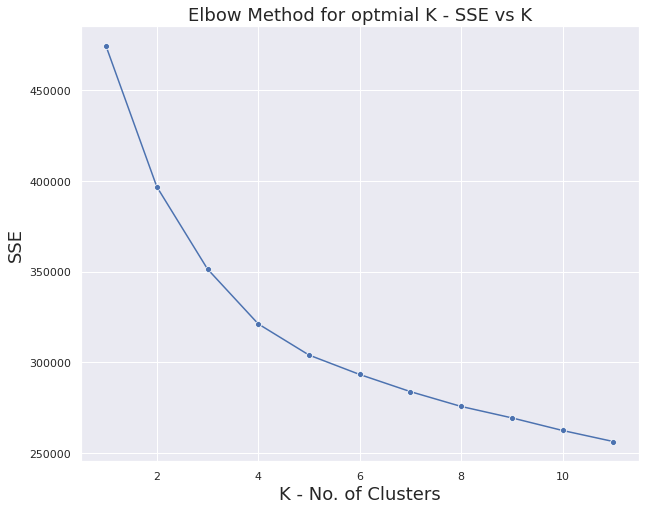

In [631]:
#Elbow plot with a line graph
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.set_style('darkgrid')
chart=sns.lineplot(ax=ax, x=K_values, y =scores, marker="o")
plt.xlabel("K - No. of Clusters", fontsize=18)
plt.ylabel("SSE", fontsize =18)
plt.title("Elbow Method for optmial K - SSE vs K", fontsize =18)

plt.show(chart)

### From the above graph we see that the elbow point could be at k=2 or 4


In [632]:
#Calcluate silhouette_score and calinski_harabasz_score for cluster 2 tp 10
for i in range(2,10):
    k_means = KMeans(n_clusters = i)
    k_means.fit(data_cluster)
    labels = k_means.labels_
    sc = metrics.silhouette_score(data_cluster, labels, metric = 'euclidean')
    ch = metrics.calinski_harabasz_score(data_cluster, labels)
    print("k = ",i,", The silhouette_score is :", sc, "Calinski Harabasz Score is: ",ch)


k =  2 , The silhouette_score is : 0.14848596075241774 Calinski Harabasz Score is:  2896.611457058076
k =  3 , The silhouette_score is : 0.14262920541245885 Calinski Harabasz Score is:  2593.259534387328
k =  4 , The silhouette_score is : 0.14292593473112017 Calinski Harabasz Score is:  2357.037478578948
k =  5 , The silhouette_score is : 0.12368477227559191 Calinski Harabasz Score is:  2077.0210983687834
k =  6 , The silhouette_score is : 0.1161204831312205 Calinski Harabasz Score is:  1832.633555527495
k =  7 , The silhouette_score is : 0.10025065990537049 Calinski Harabasz Score is:  1658.023135346938
k =  8 , The silhouette_score is : 0.10220590477377003 Calinski Harabasz Score is:  1522.4022607603338
k =  9 , The silhouette_score is : 0.10238527369864937 Calinski Harabasz Score is:  1421.2339115310922


### Based on the scores and the elbow point , we'll choose k=4 clusters. After k=4 both the scores drop considerably for the remaning clusters

###Predict and Visualize the clusters for k=4



In [633]:
km = KMeans(
    n_clusters=4)#, #init='random',
  #  n_init=10, max_iter=300, #n_init runs the kmeans algm 10 times to choose model with lowest SSE
  #  tol=1e-04, random_state=0
#).fit(data_cluster)
y_km = km.fit_predict(data_cluster)

In [634]:
np.unique(y_km)

array([0, 1, 2, 3], dtype=int32)

In [635]:
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [636]:
data_pred = data_cluster
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#df_scaled = pd.DataFrame(scaler.fit_transform(data_cluster))

data_pred['cluster'] = y_km
data_mean = data_pred.groupby('cluster').mean()

In [637]:
data_pred

,gender,age,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,offer completed bogo count,offer completed discount count,offer received bogo count,offer received discount count,offer received informational count,offer viewed bogo count,offer viewed discount count,offer viewed informational count,bogo_comp_perc,discount_comp_perc,bogo_view_perc,discount_view_perc,info_view_perc,bogo_rec_perc,discount_rec_perc,info_rec_perc,bogo_comp_ratio,discount_comp_ratio,bogo_view_ratio,discount_view_ratio,info_view_ratio,avg_difficulty,avg_duration,total_reward_received,avg_transaction_amt,cluster
0,1.063557,0.034889,2.157419,-0.349433,-0.742678,-2.313047,-2.604592,-0.017517,-1.050678,-0.707758,-1.591813,0.117481,-1.414305,-1.220437,-0.827778,1.674916,-1.674916,0.175555,-0.115927,-0.798382,0.417697,-1.663723,1.534467,1.020112,0.768385,-3.037058,0.735129,-2.287517,-1.819481,-0.539510,-0.622215,0.651692,0
1,1.063557,1.185430,1.601801,-0.189601,0.534237,-0.451989,0.493128,1.871174,-1.050678,1.083996,-1.591813,0.117481,1.439781,-1.220437,0.483312,1.674916,-1.674916,1.021875,-1.284219,0.287776,1.458629,-1.663723,0.257448,1.020112,0.768385,0.521835,0.735129,0.514554,-0.958991,-0.791364,1.015144,0.474844,1
2,-0.842540,0.782741,0.212756,-1.029314,-0.104220,-0.451989,-0.281302,-0.017517,-0.132805,-0.707758,0.178261,0.117481,-0.462943,0.739693,-0.827778,0.096256,-0.096256,-0.388658,1.052365,-0.798382,-0.623234,0.412203,0.257448,1.020112,-0.438504,0.521835,0.735129,-2.287517,-0.241916,0.999599,-0.403900,0.262264,3
3,-0.842540,0.610160,-0.574370,-0.848012,1.811152,1.409069,2.041988,1.871174,0.785067,1.979873,0.178261,-1.024585,2.391143,0.739693,-0.827778,0.411988,-0.411988,0.739768,-0.115927,-0.798382,1.111652,-0.279773,-1.019571,0.413895,0.768385,0.521835,0.735129,0.514554,-0.427512,0.220991,0.905987,-0.167743,1
4,-0.842540,0.207470,-0.666973,-0.633313,-0.742678,-1.382518,-1.055732,-0.961863,-0.132805,-1.603635,0.178261,0.117481,-1.414305,0.739693,-0.827778,-1.482403,1.482403,-1.517085,2.220657,-0.798382,-1.664166,1.104178,0.683121,0.211823,-0.438504,0.521835,0.735129,-2.287517,-0.196843,1.307421,-0.949686,-0.666792,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,1.063557,-0.540382,-0.528068,-1.122350,-1.381135,-1.382518,-0.281302,-0.961863,-1.050678,-0.707758,-0.706776,0.117481,-0.462943,-0.240372,0.483312,0.096256,-0.096256,-0.388658,-0.115927,0.649829,-0.276257,-0.279773,0.683121,-1.404753,-1.645394,0.521835,0.735129,0.514554,-0.872942,-1.462975,-1.168001,-0.729779,0
14821,-0.842540,0.380051,0.305359,-1.215386,-0.742678,-1.382518,-1.830162,-0.017517,-1.050678,-0.707758,-1.591813,1.259546,-1.414305,-1.220437,0.483312,1.674916,-1.674916,-1.517085,-1.284219,3.546253,-0.276257,-1.663723,2.385814,1.020112,0.768385,-3.037058,0.735129,-0.886481,-2.360360,-1.647668,-0.622215,-0.678300,0
14822,-0.842540,-0.310274,0.351660,0.056110,-1.381135,-1.382518,-1.830162,-0.961863,-1.050678,-1.603635,-0.706776,1.259546,-1.414305,-1.220437,0.483312,0.096256,-0.096256,-1.517085,-1.284219,3.546253,-1.664166,-0.279773,2.385814,0.211823,-1.645394,0.521835,-2.013090,-0.886481,-1.143381,-1.462975,-1.168001,-0.601989,0
14823,1.063557,1.645647,-0.713274,0.831413,0.534237,-1.382518,-0.281302,1.871174,-1.050678,1.083996,-1.591813,-1.024585,1.439781,-1.220437,-0.827778,1.674916,-1.674916,1.868195,-1.284219,-0.798382,2.499560,-1.663723,-1.019571,1.020112,0.768385,0.521835,0.735129,0.514554,0.208817,-0.231688,1.560930,-0.082347,1


###t-distributed Stochastic Neighbor Embedding (t-SNE) for visualizing the clusters

In [638]:
from sklearn.manifold import TSNE
def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

In [639]:
from matplotlib import animation
def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)
    N=10
    x=500*np.random.random(N)
    y=500*np.random.random(N)
    z=500*np.random.random(N)
    def frame(w):
      ax.clear()
      global x,y,z
      x=x+np.random.normal(loc=0.0,scale=50.0,size=10)
      y=y+np.random.normal(loc=0.0,scale=50.0,size=10)
      z=z+np.random.normal(loc=0.0,scale=50.0,size=10)

      plt.title("Brownian Motion")
      ax.set_xlabel('X(t)')
      ax.set_xlim3d(-500.0,500.0)
      ax.set_ylabel('Y(t)')
      ax.set_ylim3d(-500.0,500.0)
      ax.set_zlabel('Z(t)')
      ax.set_zlim3d(-500.0,500.0) 
      plot=ax.scatter3D(x, y, z, c='r')
      return plot
    #N=360
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    
    #ani.save('{}.gif'.format(name), writer='imagemagick')
    rc('animation', html='jshtml')
    ani = animation.FuncAnimation(fig, frame, frames=100, blit=False, repeat=True)
    ani
    #plt.show()

In [640]:
#tsne_3d_df = prepare_tsne(3, data_cluster, y_km)


In [641]:
#tsne_3d_df

In [642]:
#!apt install imagemagick

In [643]:
from matplotlib import rc
#plot_animation(tsne_3d_df, 'labels', 'labels')

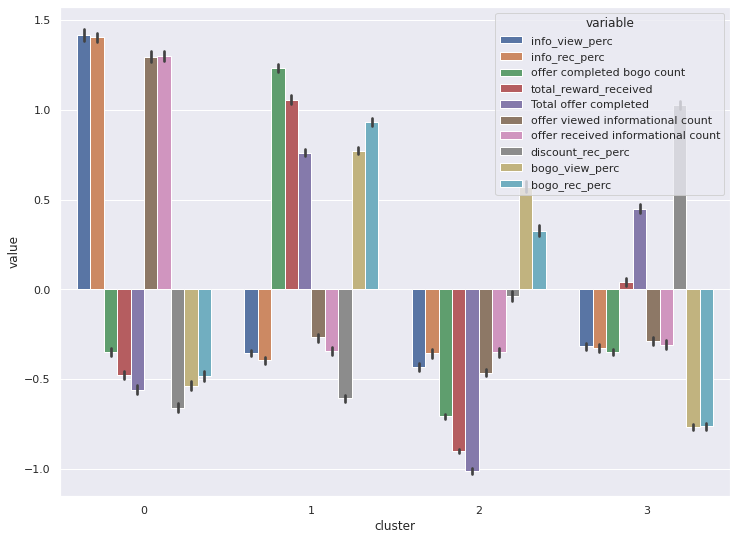

In [644]:
#Finding and plotting the top 10 features used in clus
results = pd.DataFrame(columns=['Variable', 'Var'])
for column in data_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.var(data_mean[column])]
selected_columns = list(results.sort_values('Var', ascending=False,).head(10).Variable.values) + ['cluster']
tidy = data_pred[selected_columns].melt(id_vars='cluster')
sns.set(rc={'figure.figsize':(12,9)})
sns.barplot(x='cluster', y='value', hue='variable', data=tidy)

###Visualizing the clusters based on deographic data

Cluster 0 - Red, Cluster 1 - Blue, Cluster 2 - Green, Cluster 3 - Purple

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


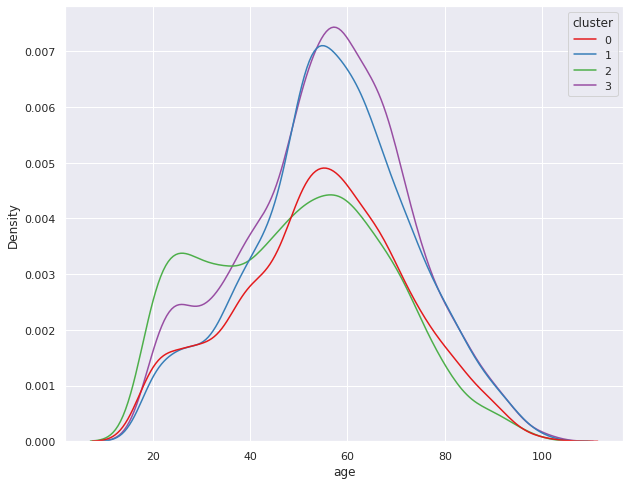

In [645]:
#Adding cluster to original data
data['cluster'] = y_km
size = (10, 8)
fig, ax = plt.subplots(figsize=size)

#Visualizing clusters across age ranges
sns.kdeplot(data = data, x='age', hue='cluster', palette="Set1" )

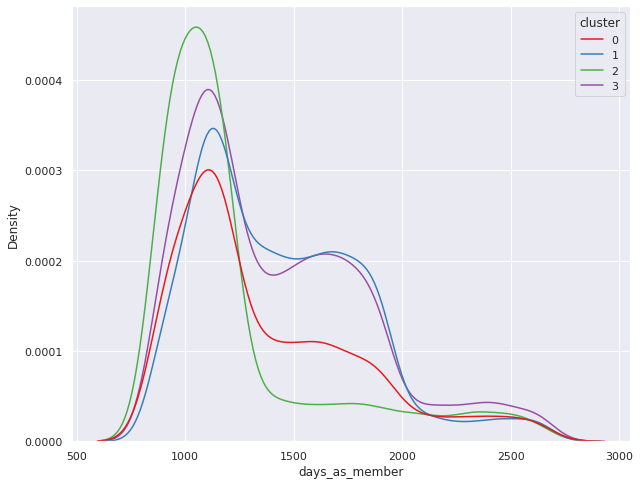

In [646]:
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.kdeplot(data = data, x='days_as_member', hue='cluster', palette="Set1",ax=ax )

Text(13.913870370370361, 0.5, 'Income')

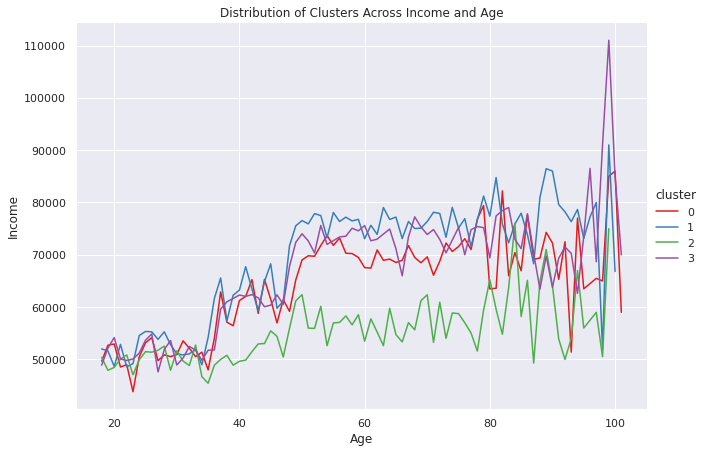

In [647]:
sns.relplot(data = data, x = 'age', y = 'income', hue = 'cluster', palette = 'Set1', kind = "line", ci=None, height=6, aspect=1.5)
plt.title('Distribution of Clusters Across Income and Age')
plt.xlabel('Age')
plt.ylabel('Income')

([<matplotlib.axis.XTick at 0x7f17dc967438>,
 [Text(0, 0, 'Male'), Text(0, 0, 'Female'), Text(0, 0, 'Other')])

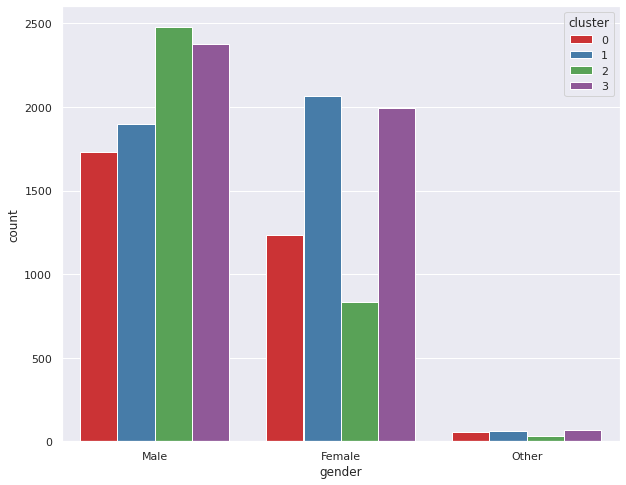

In [648]:
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.countplot(data = data, x = 'gender', hue = 'cluster', ax = ax, palette='Set1')
plt.xticks(range(3), ['Male', 'Female', 'Other'])

Based on above graph we can deduce the following info:

Cluster 0: Has relatively lower number of people and more people in the age group 50-70. The income of the people in this group is higher, especially for people above 50 years. This group has twice the number of males than females. Most members of this group have been a Starbucks member for an average duration of around 3 years.

Cluster 1: Mostly people around the age of 60. This group is the highest earning cluster with all different age groups having a very high income. Has considerably more females than Males. Most of them have been member for 3-6 years.

Cluster 2: Has more younger age group. Most people have been members for atleast 3 years. Average income range across all age groups. Has more Men than Women. 

Cluster 3: Highest number of people. Has more younger and middle aged people. More people who are comparatively new members. Average income range across all age groups. Three times more males than Females.

###Based on response to offers

In [649]:
data

,gender,age,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,offer completed bogo count,offer completed discount count,offer received bogo count,offer received discount count,offer received informational count,offer viewed bogo count,offer viewed discount count,offer viewed informational count,bogo_comp_perc,discount_comp_perc,bogo_view_perc,discount_view_perc,info_view_perc,bogo_rec_perc,discount_rec_perc,info_rec_perc,bogo_comp_ratio,discount_comp_ratio,bogo_view_ratio,discount_view_ratio,info_view_ratio,avg_difficulty,avg_duration,total_reward_received,avg_transaction_amt,cluster
0,1,55,112000.0,1230,1.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,0.500000,0.000000,0.500000,1.00,NaN,0.0,NaN,0.0,3.333333,144.000000,5.0,25.67,0
1,1,75,100000.0,1297,3.0,4.0,4.0,3.0,0.0,3.0,0.0,1.0,3.0,0.0,1.0,1.0,0.0,0.750000,0.000000,0.250000,0.750000,0.000000,0.250000,1.00,NaN,1.0,NaN,1.0,5.454545,137.454545,20.0,22.75,1
2,0,68,70000.0,945,2.0,4.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.5,0.5,0.333333,0.666667,0.000000,0.250000,0.500000,0.250000,1.00,0.5,1.0,1.0,0.0,7.222222,184.000000,7.0,19.24,3
3,0,65,53000.0,1021,5.0,6.0,6.0,3.0,2.0,4.0,2.0,0.0,4.0,2.0,0.0,0.6,0.4,0.666667,0.333333,0.000000,0.666667,0.333333,0.000000,0.75,1.0,1.0,1.0,NaN,6.764706,163.764706,19.0,12.14,1
4,0,58,51000.0,1111,1.0,3.0,2.0,0.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.000000,0.666667,0.333333,NaN,0.5,NaN,1.0,0.0,7.333333,192.000000,2.0,3.90,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,1,45,54000.0,906,0.0,3.0,3.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.00,0.0,1.0,1.0,1.0,5.666667,120.000000,0.0,2.86,0
14821,0,61,72000.0,867,1.0,3.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.000000,1.000000,0.333333,0.000000,0.666667,1.00,NaN,0.0,NaN,0.5,2.000000,115.200000,5.0,3.71,0
14822,0,49,73000.0,1400,0.0,3.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,NaN,NaN,0.000000,0.000000,1.000000,0.000000,0.333333,0.666667,NaN,0.0,NaN,0.0,0.5,5.000000,120.000000,0.0,4.97,0
14823,1,83,50000.0,1725,3.0,3.0,3.0,3.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00,NaN,1.0,NaN,NaN,8.333333,152.000000,25.0,13.55,1


Text(0, 0.5, 'bogo_view_ratio')

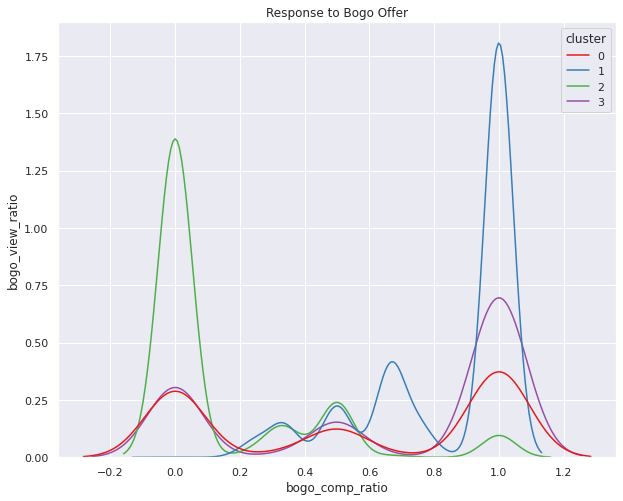

In [650]:
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.kdeplot(ax=ax, data = data, x = 'bogo_comp_ratio', hue = 'cluster', palette = 'Set1',)
plt.title('Response to Bogo Offer')
plt.xlabel('bogo_comp_ratio')

Text(0.5, 0, 'bogo_view_ratio')

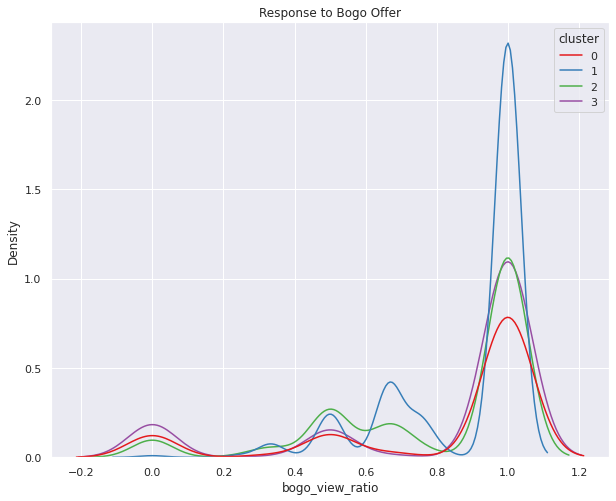

In [653]:
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.kdeplot(ax=ax, data = data, x = 'bogo_view_ratio', hue = 'cluster', palette = 'Set1',)
plt.title('Response to Bogo Offer')
plt.xlabel('bogo_view_ratio')

Text(0.5, 0, 'discount_comp_ratio')

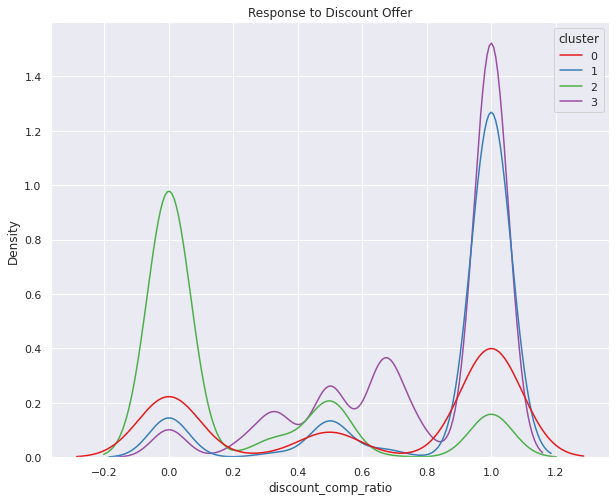

In [651]:
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.kdeplot(ax=ax, data = data, x = 'discount_comp_ratio', hue = 'cluster', palette = 'Set1',)
plt.title('Response to Discount Offer')
plt.xlabel('discount_comp_ratio')

Text(0.5, 0, 'discount_view_ratio')

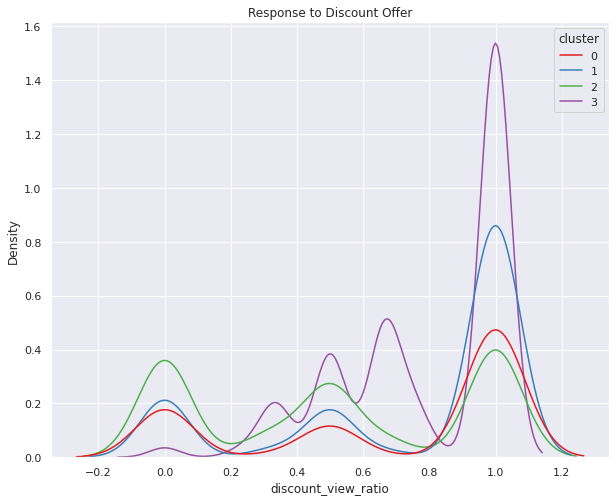

In [654]:
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.kdeplot(ax=ax, data = data, x = 'discount_view_ratio', hue = 'cluster', palette = 'Set1',)
plt.title('Response to Discount Offer')
plt.xlabel('discount_view_ratio')

Text(0.5, 0, 'info_view_ratio')

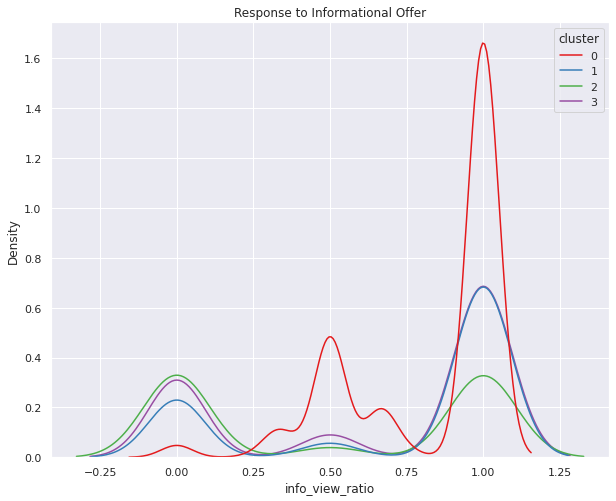

In [655]:
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.kdeplot(ax=ax, data = data, x = 'info_view_ratio', hue = 'cluster', palette = 'Set1',)
plt.title('Response to Informational Offer')
plt.xlabel('info_view_ratio')

In [652]:
\x = ['total_completion_ratio', 
    'income',
    'Total transaction amount']

X = data[x].to_numpy()

sc = StandardScaler()
X = sc.fit_transform(X)
X

SyntaxError: ignored

In [ ]:
k_means = KMeans(n_clusters = 2)
k_means.fit(d)

In [ ]:
# Visualising the clusters
labels = k_means.labels_
cluster_centers = k_means.cluster_centers_

print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters:", n_clusters_)

colors = 10*['r','g','b','c','k','y','m']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(d)):
    ax.scatter(d[i][0], d[i][1], c=colors[labels[i]], marker='o')

ax.scatter(cluster_centers[:,0],cluster_centers[:,1],
            marker="x",color='k', s=150, linewidths = 5, zorder=10)
ax.legend()

ax.set_xlabel(x[0])
ax.set_ylabel(x[1])
ax.set_zlabel(x[2])

plt.show()

In [ ]:
k_means3 = KMeans(n_clusters = 4)
k_means3.fit(X)

In [ ]:
# Visualising the clusters
labels = k_means3.labels_
cluster_centers = k_means3.cluster_centers_

print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters:", n_clusters_)

colors = 10*['r','g','b','c','k','y','m']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(X)):
    ax.scatter(X[i][0], X[i][1], X[i][2], c=colors[labels[i]], marker='o')

ax.scatter(cluster_centers[:,0],cluster_centers[:,1],cluster_centers[:,2],
            marker="x",color='k', s=150, linewidths = 5, zorder=10)
ax.legend()

ax.set_xlabel(x[0])
ax.set_ylabel(x[1])
ax.set_zlabel(x[2])

plt.tight_layout()
plt.show()

In [ ]:
k_means2 = KMeans(n_clusters = 5)
k_means2.fit(X)

In [ ]:
# Visualising the clusters
labels = k_means2.labels_
cluster_centers = k_means2.cluster_centers_

print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters:", n_clusters_)

colors = 10*['r','g','b','c','k','y','m']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(X)):
    ax.scatter(X[i][0], X[i][1], X[i][2], c=colors[labels[i]], marker='o')

ax.scatter(cluster_centers[:,0],cluster_centers[:,1],cluster_centers[:,2],
            marker="x",color='k', s=150, linewidths = 5, zorder=10)
ax.legend()

ax.set_xlabel(x[0])
ax.set_ylabel(x[1])
ax.set_zlabel(x[2])

plt.show()

In [ ]:
x = ['age', 
    'income',
    'gender']

X = cust_data.to_numpy()

sc = StandardScaler()
X = sc.fit_transform(X)
X


k_means = KMeans(n_clusters = 2)
k_means.fit(X)

In [ ]:
x = ['age', 
    'income',
    'gender']

X = cust_data[x].to_numpy()

sc = StandardScaler()
X = sc.fit_transform(X)
cust_data = X

#We can verify this by calculating the Silhouette coefficient and Calinski Harabasz Scores for k=5 and other values
#k=6
k_means = KMeans(n_clusters = 6)
k_means.fit(cust_data)

labels = k_means.labels_
sc = metrics.silhouette_score(cust_data, labels, metric = 'euclidean')
ch = metrics.calinski_harabasz_score(cust_data, labels)
print("k = 6, The silhouette_score is :", sc, "Calinski Harabasz Score is: ",ch)
# print(k_means.cluster_centers_)

In [ ]:
#We can verify this by calculating the Silhouette coefficient and Calinski Harabasz Scores for k=5 and other values
#k=5
k_means = KMeans(n_clusters = 5)
k_means.fit(cust_data)

labels = k_means.labels_
sc = metrics.silhouette_score(cust_data, labels, metric = 'euclidean')
ch = metrics.calinski_harabasz_score(cust_data, labels)
print("k = 5, The silhouette_score is :", sc, "Calinski Harabasz Score is: ",ch)
# print(k_means.cluster_centers_)

In [ ]:
#We can verify this by calculating the Silhouette coefficient and Calinski Harabasz Scores for k=5 and other values
#k=4
k_means = KMeans(n_clusters = 4)
k_means.fit(cust_data)
predicted = k_means.predict(cust_data)
labels = k_means.labels_
sc = metrics.silhouette_score(cust_data, labels, metric = 'euclidean')
ch = metrics.calinski_harabasz_score(cust_data, labels)
print("k = 4, The silhouette_score is :", sc, "Calinski Harabasz Score is: ",ch)

In [ ]:
#We can verify this by calculating the Silhouette coefficient and Calinski Harabasz Scores for k=5 and other values
#k=3
k_means = KMeans(n_clusters = 3)
k_means.fit(cust_data)

labels = k_means.labels_
cluster_centers = k_means.cluster_centers_

sc = metrics.silhouette_score(cust_data, labels, metric = 'euclidean')
ch = metrics.calinski_harabasz_score(cust_data, labels)
print("k = 3, The silhouette_score is :", sc, "Calinski Harabasz Score is: ",ch)
# print(k_means.cluster_centers_)

In [ ]:
#We can verify this by calculating the Silhouette coefficient and Calinski Harabasz Scores for k=5 and other values
#k=2
k_means = KMeans(n_clusters = 2)
k_means.fit(cust_data)

labels = k_means.labels_
cluster_centers = k_means.cluster_centers_

sc = metrics.silhouette_score(cust_data, labels, metric = 'euclidean')
ch = metrics.calinski_harabasz_score(cust_data, labels)
print("k = 2, The silhouette_score is :", sc, "Calinski Harabasz Score is: ",ch)
# print(k_means.cluster_centers_)

In [ ]:
x = ['age', 
    'income',
    'gender']

X = cust_data[x].to_numpy()

sc = StandardScaler()
X = sc.fit_transform(X)
X

In [ ]:
k_means_age = KMeans(n_clusters = 3)
k_means_age.fit(X)

In [ ]:
# Visualising the clusters
labels = k_means_age.labels_
cluster_centers = k_means_age.cluster_centers_

print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters:", n_clusters_)

colors = 10*['r','g','b','c','k','y','m']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(X)):
    ax.scatter(X[i][0], X[i][1], X[i][2], c=colors[labels[i]], marker='o')

ax.scatter(cluster_centers[:,0],cluster_centers[:,1],cluster_centers[:,2],
            marker="x",color='k', s=150, linewidths = 5, zorder=10)
ax.legend()

ax.set_xlabel(x[0])
ax.set_ylabel(x[1])
ax.set_zlabel(x[2])

plt.show()